## Goal
Complexify the previous 1-hidden layer multi-layer perceptron.
* More characters in a sequence as context
* Using the architeture similar to Wavenet rather than squashing too much information quickly in one single hidden layer

## Starter code
Copy and paste from part 3: Activations, Gradients, and Batch Normalization

* Read in all the words
* Build the vocabulary of characters and mappings to/from integers
* Build the dataset

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# Read in all the words
words = open("names.txt").read().splitlines()
len(words), words[:10]

(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [15]:
# Build the vocabulary of characters and mappings to/from integers
vocab = sorted(set(''.join(words)))

stoi = {s: i+1 for i, s in enumerate(vocab)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos) # Used for initiate emb lookup table

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [16]:
# Build the dataset
block_size = 8 # context_length: how many characters do we take to predict the next one?
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+".":
            idx = stoi[ch]
            xs.append(context), ys.append(idx)
            context = context[1:] + [idx]
    xs, ys = torch.tensor(xs), torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

import random
random.seed(42)
random.shuffle(words)
train_idx = int(0.8 * len(words))
val_idx   = int(0.9 * len(words))

x_train, y_train = build_dataset(words[:train_idx])
x_val  , y_val   = build_dataset(words[train_idx:val_idx])
x_test , y_test  = build_dataset(words[val_idx:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [17]:
for x, y in zip(x_train[:20], y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [74]:
# PyTorchified code block
# generator g is removed and set as a gobal random seed in next cell.
class Linear:
    """
    class torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    """
    def __init__(self, in_feature, out_feature, bias=True):
        # Initialize weights and bias
        self.weights = torch.randn((in_feature, out_feature)) / in_feature ** 0.5
        self.bias = torch.zeros(out_feature) if bias else None
    
    def __call__(self, x):
        # Forward pass
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        # Return a list of weighs and bias if bias is not None
        return [self.weights] + ([self.bias] if self.bias is not None else [])
    
class BatchNorm1D:
    """
    class torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)[source]
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        # Initialize eps, momentum, training or not
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Initialize gamma and beta if affine = True. Params trained with backprop
        if affine:
            self.gamma = torch.ones(num_features)
            self.beta = torch.zeros(num_features)
        # Buffers (Trained internally with a running momentum update)
        self.mean_running = torch.zeros(num_features)
        self.var_running = torch.ones(num_features)
        
    
    def __call__(self, x):
        # If training, calculate the mean and std for x. Otherwise, use the buffer
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else:
            xmean = self.mean_running
            xvar = self.var_running
        # Normalize to unit variance as xhat
        x_hat = (x - xmean) / torch.sqrt(xvar + self.eps)
        # Scale and shift to out.
        self.out = self.gamma * x_hat + self.beta
        # Update mean and std buffer if training with momentum update. without grad.
        if self.training:
            with torch.no_grad():
                self.mean_running = (1 - self.momentum) * self.mean_running + self.momentum * xmean
                self.var_running = (1 - self.momentum) * self.var_running + self.momentum * xvar
        return self.out
    
    def parameters(self):
        # Return a list of gamma, beta.
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        # Return tanh x
        self.out = torch.tanh(x)
        return self.out
        
    def parameters(self):
        # Return empty list
        return []

# PyTorchifying layers to simplify model construction
# torch.embeddings, torch.flatten
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        """
        n: how many consecutive characters we want to fuse
        """
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape # batch, context_length, embd_dim
        x = x.view(B, T // self.n, self.n * C)
        
        # If we are fusing all characters in the context
        if x.shape[1] == 1:
            x = x.squeeze(dim=1)
        
        self.out = x
        return self.out
    
    def parameters(self):
        return []

# Container
class Sequential:
    """
    In the forward, we call layers sequentially
    """
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # Get parameters of all layers and stretch them into a list.
        return [p for layer in self.layers for p in layer.parameters()]

In [60]:
torch.manual_seed(42); # Seed rng for reproducibility

In [98]:
n_embd = 10 # The dimensionality of the character embedding vectors
n_hidden = 68 # The number of neurons in the hidden layer of the MLP

# C = torch.randn((vocab_size, n_embd))
model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(n=2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(n=2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# Parameter inits
with torch.no_grad():
    model.layers[-1].weights *= 0.1 # Last layer make less confidently wrong

# parameters = [p for layer in layers for p in layer.parameters()]
parameters = model.parameters()
print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

22397


Scroll down to bottom to inspect tensors of the forward pass

In [21]:
max_steps = 200000
batch_size = 32
lossi = []

for step in range(max_steps):
    # Batch index
    idx = torch.randint(0, x_train.shape[0], (batch_size, ))
    xb, yb = x_train[idx], y_train[idx]
    
    # Forward
#     emb = C[xb]
#     x = emb.view(batch_size, -1)
#     x = xb
#     for layer in layers:
#         x = layer(x)
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    
    # Backward
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if step < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    if step % 10000 == 0:
        print(f"{step:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6867
 170000/ 200000: 2.0968
 180000/ 200000: 1.7824
 190000/ 200000: 1.9151


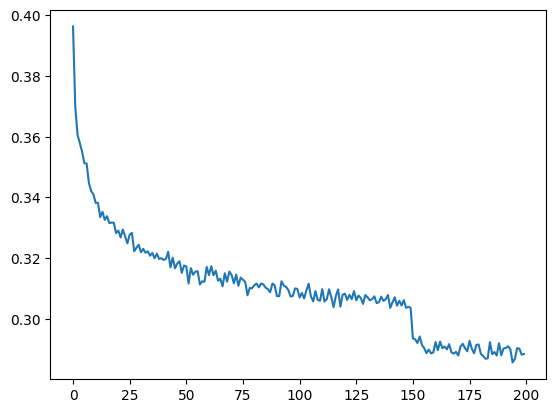

In [22]:
# Each row is now going to be 1000 consecutive loss numbers.
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(dim=1))

In [23]:
# Put layers into eval mode (needed for batchnorm to disable mean_running update)
for layer in model.layers:
    layer.training = False

In [24]:
# Evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (x_train, y_train),
        "val"  : (x_val  , y_val),
        "test" : (x_test , y_test)
    }[split]
    
#     emb = C[x]
#     x = emb.view(emb.shape[0], -1)
#     for layer in layers:
#         x = layer(x)
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss("train")
split_loss("val")

train 1.9163438081741333
val 2.034248113632202


### Performance log
* original (3 character context + 200 hidden neurons, 12K params): 
    * train 2.058220624923706
    * val 2.1056690216064453
* 8 character context + 200 hidden neurons, 22K params:
    * train 1.9163438081741333
    * val 2.034248113632202

Heads up:
* torch.tensor(context) will get a shape of [3] with 3 rows.
* torch.tensor([context]) will give the correct results with [1, 3] shape.

In [25]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # Notice that if you do torch.tensor(context) will get [0, 0, 0] which has a shape of [3] with 3 rows.
        logits = model(torch.tensor([context]))
#         emb = C[torch.tensor([context])]
#         x = emb.view(emb.shape[0], -1)
#         for layer in layers:
#             x = layer(x)
#         logits = x
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[iout] for iout in out))

melae.
lynn.
gwesen.
macoy.
delia.
chrelan.
jaquin.
dayana.
haziyah.
hamilin.
dacy.
grayman.
abella.
kaklyn.
cash.
hamby.
dencelyuh.
card.
malizen.
ronni.


## PyTorchifying
* `torch.Embeddings`, `torch.Flatten` to simplify model construction.
* Container: `torch.nn`. `nn.Sequential()` and `model.parameter()`

## Increase block_size to 8 and rerun

In [ ]:
block_size = 3 # context_length: how many characters do we take to predict the next one?

## Inspect fordward pass
* Look at the forward pass of the neural net
* Inspect the shape of the tensors along the way as the neural net forwards

Start by debugging a small batch of 4 examples

In [94]:
ix = torch.randint(0, x_train.shape[0], (4,))
Xb, Yb = x_train[ix], y_train[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0, 13,  1, 18, 19],
        [ 0,  0,  0, 15,  1, 11, 12,  5],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [85]:
# The first layer is the Embedding Layer
# Passing [4,8] will create an output of [4,8,embd_dim]
# Our embedding table has a 10-dimensional vector that we are trying to learn for each character.
# The embedding layer pleaks out the embedding vector for each one of above integers and organizes
# it all in a [4,8,10] tensor.
# All integers are translated into 10 dimensional vectors.
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [64]:
# Passing above into flatten layer. What this does is it views this tensor
# as a 4 by 80 tensor. All these 10 dimensional vectors for 8 characters just
# end up being stretched out into a long row.
model.layers[1].out.shape

torch.Size([4, 80])

In [65]:
# The linear layer takes 80 and creates 200 channels via matrix multiplication
model.layers[2].out.shape

torch.Size([4, 200])

In [66]:
# What above linear layer does equals to
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
(torch.randn(4, 5, 2, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 2, 200])

In [96]:
for layer in model.layers:
    print(layer.__class__.__name__, tuple(layer.out.shape))

Embedding (4, 8, 10)
FlattenConsecutive (4, 4, 20)
Linear (4, 4, 200)
BatchNorm1D (4, 4, 200)
Tanh (4, 4, 200)
FlattenConsecutive (4, 2, 400)
Linear (4, 2, 200)
BatchNorm1D (4, 2, 200)
Tanh (4, 2, 200)
FlattenConsecutive (4, 400)
Linear (4, 200)
BatchNorm1D (4, 200)
Tanh (4, 200)
Linear (4, 27)


The matrix multiplication only works on the last dimension and the dimensions before it in the input tensor are left unchanged.

## WaveNet Construction
1, 2, 3, 4, 5, 6, 7, 8

Now we don't want to flatten all these 8 characters as we don't want to Matrix multiply 80 into a weight matrix multiplication immediately. Instead, we want group these. Every consecutive elements should be flattened out as 4 groups.

(1, 2,) (3, 4,) (5, 6,) (7, 8)

In [33]:
# We only want 2 character to come in on the very first layer.
# Those 2 characters shuold be fused.
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

We need to change the linear layer and acheieve what we want to get to.
So we also have to change the flatten layer so it doesn't fully flatten out the input.

In [38]:
# Get odd and even elements
list(range(10))[::2]
list(range(10))[1::2]

[0, 2, 4, 6, 8]

In [42]:
# Way 1: Explicit how it works
e = torch.randn(4, 8, 10) # Goal: to be (4, 4, 20) where consecutive 10-d vector get concantenated
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [44]:
# Way 2: tensor.view
e.view(4, 4, 20) == explicit

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True]],

        [[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [T

Use `tensor.view()` to change how `Flatten` defined above. We want to give a number to indicate how many consecutive characters we want to fuse.

Change `hidden_dim` to 68 so that the model will have similar capacity of 22k param as before

In [97]:
n_hidden = 68 # The number of neurons in the hidden layer of the MLP